# Conformal Predictions for ML Models (Dupont)

This is a notebook dedicated to the python implementation of the conformal prediction framework for ml models.

**Index**
* [Library Imports](#library_imports)
* [Enviroments & Models Function](#environment_models) 
* [Data Split Function](#data_split)
* [NonConformist Class](#nonconformal_class)
* [Loading Model and Environments](#Loading_Model)
* [Data Setup](#data_setup)
* [Training and Calibration Procedure](#training_calibration)
* [Efficiency and Validity](#efficiency_validity)


<a id='library_imports'></a>
## Library Imports

Import necessary modules for notebook

In [8]:
import dotenv
import prolerep.analysis.utils as utils
import mlflow.sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dotenv
dotenv.load_dotenv(".env")

True

<a id='environment_models'></a>
## Load Environment and Models Function
* Function comitted to preparing the environment variables and model to be used

In [9]:
def model_prep():
    runs = mlflow.search_runs(26) #ExperimentID:(4:Expression,13:Activity,14:Stability)
    cols = ["run_id", "params.model_name", "metrics.valid_r_square",
        "metrics.train_r_square", "params.prepared_dataset_uri"]
    best = (
    runs
    .sort_values("metrics.valid_r_square", ascending=False)
    .groupby("params.model_name")
    .head(n=1)
    [cols]
    .set_index("params.model_name"))    
    #PLS_Model = mlflow.pyfunc.load_model(f"runs:/{best.loc['EinsumRun'].run_id}/logged_model", suppress_warnings=False)
    PLS_Model = mlflow.sklearn.load_model(f"runs:/{best.loc['PLSRun'].run_id}/logged_model")
    print("Environment and Models have been loaded")
    return PLS_Model

<a id='data_split'></a>
## Data Split Function
* Function dedicated to splitting original dataset

In [10]:
def data_split(df):
    train = df.loc[df['split'] == 'train']
    valid = df.loc[df['split'] == 'valid']
    valid = valid.drop('split', 1)
    train = train.drop('split', 1)
    X_test = valid.iloc[:,:-1]
    y_test = valid.iloc[:,-1] 
    X_train = train.iloc[:,:-1] 
    y_train = train.iloc[:,-1] 
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size =0.2)
    print("Data has been split")
    print("X_train and y_train shape: "+ str(X_train.shape) + str(y_train.shape))
    print("X_cal and y_cal shape: "+ str(X_cal.shape) + str(y_cal.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   X_train.shape[1],
                                                   np.unique(y_train).size))
    return X_test, y_test, X_train, y_train, X_cal, y_cal


<a id='Evaluation_Class'></a>
## Evaluation Class

In [12]:
class Evaluation():
    
    def __init__(self):
        pass
    
    #########################
    ## Efficiency Measures ##
    #########################
    def prediction_size(self, predictions):
        """
        Calculates the general and average prediction interval size 
        based on a conformal prediction regression model.
        
        @params
        prediction_intervals: Prediction Intervals determined from the test patterns
        
        returns:
        
        Interval Size: Array that contains the size of the predicted intervals
        """
        interval_size = predictions[:, 1] - predictions[:, 0] #Efficiency measure
        mean_size = np.mean(interval_size)
        
        return interval_size, mean_size    
    
    def evaluation_table(self, predictions, size, y):
        '''
        Gives a final table that contains the prediction intervals, their size
        and original (true) labels of the test patterns. 
        Allows to determine efficiency of predictions
        
        @params
        predictions: Prediction intervals determined from the test patterns
        size: Size of the respective prediction intervals
        y: array of the true labels (i.e. y_test)
        
        returns:
        
        Tabulated results for the evaluation function
        ''' 
        header = ['Min','Max','Original Label','Interval Size']
        table = np.vstack([predictions.T, y, size.T]).T
        predictions_table = pd.DataFrame(table, columns = header)

        return predictions_table


    #########################
    ## Validity Measures ####
    #########################
    
    def correct_predictions(self, predictions, y_test, significance = None):
        """
        Calculates the number of correct predictions (error rate) made by
        the conformal functions in a regression model and its average error rate.
        
        @params
        predictions: Prediction intervals determined from the test patterns
        y: array of the true labels (i.e. y_test)
        significance: Float value between 0-1 (i.e. 0.05)
        """
        
        idx = int(significance * 100 - 1)
        prediction = predictions[:idx]
        
        low = y_test >= predictions[:, 0]
        high = y_test <= predictions[:, 1]
        correct = low * high
        
        predictions_rate = y_test[correct].size
        avg_error_rate = 1 - predictions_rate / y_test.size

        return predictions_rate, avg_error_rate


### Running Functions and Class Methods

#### Loading Environments and Model
<a id='Loading_Model'></a>

In [15]:
env = ".env"
PLS_Model = model_prep() #Used to predict original target: Expression

Environment and Models have been loaded


/home/john/my_virtual_env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/my_virtual_env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/my_virtual_env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/my_virtual_env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PLSRegression from version 0.22.2.post1 when using

#### Data Setup
<a id='data_setup'></a>
* Divide training data into two subsets (proper training and calibration data)

In [16]:
df = utils.read_csv_from_s3("s3://mlflow/4/1a163dd9fecc435fbf340dbdd5170cb9/artifacts/dataset.csv") #Upload dataset from MLFlow
X_test, y_test, X_train, y_train, X_cal, y_cal = data_split(df)
df.head()

Data has been split
X_train and y_train shape: (11694, 2)(11694,)
X_cal and y_cal shape: (2924, 2)(2924,)
11694 instances, 2 features, 10547 classes


,new_host,split,sequence,expression
0,False,train,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.039268
1,False,train,--ASVPYGVSQIKAPALH-SQGYTGSNVKVAVIDSGIDSSHPDLKV...,0.039268
2,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.261457
3,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.265189
4,False,train,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,0.419681


#### Training and Calibration Procedure
* Train the underlying model
* Define Non-Conformity function, measure nonconformity of calibration examples and obtain their respective nonconformal scores
<a id='training_calibration'></a>


In [19]:
#Step 1
PLS_Model.fit(X_train, y_train) 

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('sequence',
                                                  MutationsFeatureTransformer(),
                                                  ['sequence']),
                                                 ('numerical', 'passthrough',
                                                  []),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['new_host'])])),
                ('standard_scaler', StandardScaler()),
                ('regressor', PLSRegression(n_components=10))])

In [58]:
def apply_nonconformity(calibration_predictions, y_cal):
    '''
    Calculates absolute error nonconformity scores for calibration set.
    For each correct output in ``y``, nonconformity is defined as
    math::
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
        
    Returns:
    Calibration scores: numpy array of shape [n_samples]
    Non conformity scores of the samples
    '''
    
    true_labels = np.array(y_cal)
    calibration_predictions = calibration_predictions.flatten()
    std_dev = np.std(calibration_predictions)
    conformity_scores = (np.abs(true_labels - calibration_predictions)/std_dev)
    
    
    conformity_scores = np.sort(conformity_scores)[::-1] #sort in descending order
    print("Calibration Conformal Scores Obtained")
        
    return conformity_scores

In [59]:
#Step 2
calibration_predictions = PLS_Model.predict(X_cal)
print("Calibration predictions have been established")
calibration_predictions

Calibration predictions have been established


array([[0.37133753],
       [0.51525168],
       [0.64494316],
       ...,
       [0.56642891],
       [0.85310801],
       [0.24067335]])

In [60]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(y_cal,calibration_predictions))

R2 score : 0.51


In [64]:
#Step 3: Calculating NonConformity Scores
conformity_scores = apply_nonconformity(calibration_predictions, y_cal)
conformity_scores

Calibration Conformal Scores Obtained


array([4.39564637e+00, 3.75359122e+00, 3.62021160e+00, ...,
       7.94223077e-04, 1.09938227e-04, 1.01422677e-04])

In [74]:
def conformal_predictions(model, X_test, conformity_scores, significance):
    """
    Function will construct the prediction intervals 
    for a set of test examples. 
        
    This applies the partial inverse nonconformity function
    to each prediction from the underlying model, thus
    resulting in a prediction interval for each test pattern.

    @params
        ----------
    X_test: Numpy array of shape [n_samples, n_features]
    Inputs of test patterns for which to predict final output values

    Significance: Considered a float between 0 and 1; determimned as 
    the maximum allowed error rate of predictions.
        
    Returns
    -------
    p : numpy array of shape [n_samples, 2] or [n_samples, 2, 99]
    When significance value is a float between 0 and 1, then p 
    contains the prediction intervals (minimum and maximum boundaries)
    for the set of test patterns at the chosen significance level.
    """
    n_test = X_test.shape[0] #Takes shape of X_test row number
    norm = np.ones(n_test) #Returns an array of X_test shape, filled with ones.
    test_predictions = model.predict(X_test) #Predictions from test data
    test_predictions = test_predictions.flatten() #Returns a collapsed array as 1D

    upper = int(np.floor((0.05 / 2) * (conformity_scores.size + 1)))
    lower = int(np.floor((1 - 0.05 / 2) * (conformity_scores.size + 1)))
    upper = min(max(upper, 0), conformity_scores.size - 1)
    lower = max(min(lower, conformity_scores.size - 1), 0)
    
    err_dist = np.vstack([-conformity_scores[lower], conformity_scores[upper]])
    err_dist = np.hstack([err_dist] * n_test) ##Stack arrays in sequence horizontally (column wise)
    err_dist *= norm
    
    intervals = np.zeros((X_test.shape[0], 2)) #Creates empty 2D numpy array for saving prediction intervals
    intervals[:, 0] = test_predictions - err_dist[0, :] #[0] creates lower boundary of the prediction interval
    intervals[:, 1] = test_predictions + err_dist[1, :] #[1] creates upper boundary of the prediction interval
    print("Prediction Intervals Created")

    return intervals

In [67]:
conformity_scores

array([9.27735755e-01, 8.37399887e-01, 8.30660603e-01, ...,
       7.46740009e-05, 7.24193807e-05, 3.81810737e-05])

In [81]:
prediction_intervals = conformal_predictions(PLS_Model, X_test, conformity_scores, significance = 0.05)
prediction_intervals

Prediction Intervals Created


array([[0.36866726, 2.6429089 ],
       [0.32882686, 2.60306851],
       [0.59622031, 2.87046196],
       ...,
       [0.51902773, 2.79326937],
       [0.88030859, 3.15455024],
       [0.82119952, 3.09544117]])

In [78]:
def prediction_size(prediction_intervals):
    """
    Calculates the general and average prediction interval size 
    based on a conformal prediction regression model.
        
    @params
    prediction_intervals: Prediction Intervals determined from the test patterns
        
    returns:
        
    Interval Size: Array that contains the size of the predicted intervals
    """
    interval_size = prediction_intervals[:, 1] - prediction_intervals[:, 0] #Efficiency measure
        
    return interval_size  

In [80]:
interval_size = prediction_size(prediction_intervals)
interval_size

array([2.27424165, 2.27424165, 2.27424165, ..., 2.27424165, 2.27424165,
       2.27424165])

In [86]:
def evaluation_table(prediction_intervals, interval_size, y):
    '''
    Gives a final table that contains the prediction intervals, their size
    and original (true) labels of the test patterns. 
    Allows to determine efficiency of predictions
        
    @params
    predictions: Prediction intervals determined from the test patterns
    size: Size of the respective prediction intervals
    y: array of the true labels (i.e. y_test)
        
    returns:
        
    Tabulated results for the evaluation function
    ''' 
    header = ['Min','Max','Original Label','Interval Size']
    table = np.vstack([prediction_intervals.T, y, interval_size.T]).T
    predictions_table = pd.DataFrame(table, columns = header)

    return predictions_table

In [88]:
table = evaluation_table(prediction_intervals, interval_size, y_test)
table

,Min,Max,Original Label,Interval Size
0,0.368667,2.642909,0.039268,2.274242
1,0.328827,2.603069,0.039268,2.274242
2,0.596220,2.870462,0.335382,2.274242
3,0.295341,2.569583,0.144229,2.274242
4,0.273843,2.548085,0.146150,2.274242
...,...,...,...,...
3598,0.521420,2.795661,0.422425,2.274242
3599,0.460579,2.734821,0.102519,2.274242
3600,0.519028,2.793269,0.079030,2.274242
3601,0.880309,3.154550,0.923660,2.274242


Test Predictions Established


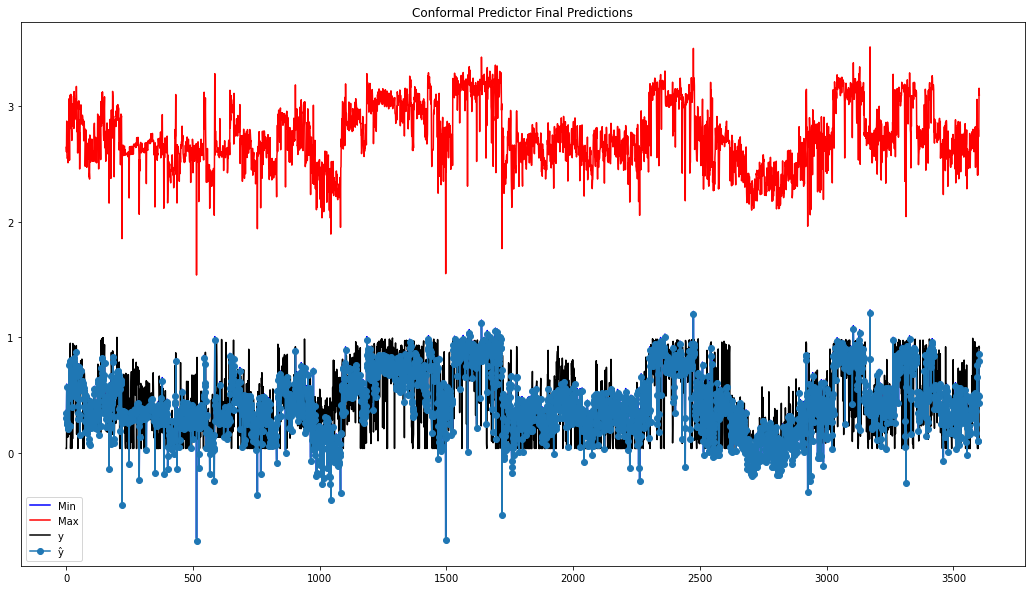

In [89]:
fig = plt.figure(1, figsize = (18,10)) # Figure size in inches (size_x, size_y)
ax = plt.axes()
min_val = prediction_intervals[:, 0]
max_val = prediction_intervals[:, 1]
true_values = y_test.to_numpy()
predicted_values = nc.test_predict(X_test) #Predictions from test data (run at least once for the plot to work)
plt.plot(min_val, label = "Min", color='blue')
plt.plot(max_val, label = "Max", color='red')
plt.plot(true_values, label = "y", color = "black")
plt.plot(predicted_values, label = "y\u0302", marker='o')
plt.title('Conformal Predictor Final Predictions')
plt.legend()
plt.show()